In [1]:
# %% [markdown]
# # VAD vs Valence — Summary Tables & Plots
# This notebook builds Table S1 and two figures from:
# - review/*review_top10_mixed.csv (diagnostic top-10 per book)
# - chunks/chunks_summary.csv (coverage + chunk counts)

# %%
from pathlib import Path
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# --- Locate folders/files robustly -------------------------------------------
BASE = Path.cwd()

def first_dir(cands, pattern=None):
    for c in cands:
        p = (BASE / c).resolve()
        if p.exists():
            if pattern is None:
                return p
            if list(p.glob(pattern)):
                return p
    return None

REVIEW_DIR = first_dir(["review", "../review", "../../review"], pattern="*review_top10_mixed.csv") or BASE
CHUNKS_DIR = first_dir(["chunks", "../chunks", "../../chunks"], pattern="*.chunks.csv") or (BASE / "chunks")
FIG_DIR = (BASE / "figs"); FIG_DIR.mkdir(exist_ok=True, parents=True)
TAB_DIR = (BASE / "tables"); TAB_DIR.mkdir(exist_ok=True, parents=True)

print("REVIEW_DIR:", REVIEW_DIR)
print("CHUNKS_DIR:", CHUNKS_DIR)
print("FIG_DIR:", FIG_DIR)
print("TAB_DIR:", TAB_DIR)

# --- Book list and readable names -------------------------------------------
BOOKS = [
    "Frankenstein.clean",
    "Mobi Dick.clean",
    "Pride and Prejudice.clean",
    "Romeo and Juliet.clean",
    "The Adventures of Sherlock Holmes.clean",
]
NICE = {
    "Frankenstein.clean": "Frankenstein",
    "Mobi Dick.clean": "Moby Dick",
    "Pride and Prejudice.clean": "Pride & Prejudice",
    "Romeo and Juliet.clean": "Romeo & Juliet",
    "The Adventures of Sherlock Holmes.clean": "Sherlock Holmes",
}

# --- Utilities ---------------------------------------------------------------
def zscore(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").astype(float)
    return (s - s.mean()) / (s.std(ddof=0) + 1e-8)

def ensure_metrics(df):
    """Add theta_deg, opp_A, opp_D if not already present."""
    for col in ["v_roll","a_roll","d_roll"]:
        if col not in df.columns:
            raise ValueError(f"Missing required column '{col}' in review CSV.")
    v = pd.to_numeric(df["v_roll"], errors="coerce")
    a = pd.to_numeric(df["a_roll"], errors="coerce")
    d = pd.to_numeric(df["d_roll"], errors="coerce")
    # angle away from valence axis in degrees
    mag = np.sqrt(v**2 + a**2 + d**2) + 1e-12
    theta = np.degrees(np.arccos(np.clip(np.abs(v) / mag, 0, 1)))
    if "theta_deg" not in df.columns:
        df["theta_deg"] = theta
    # z’s for opposition flags
    vz, az, dz = zscore(v), zscore(a), zscore(d)
    if "opp_A" not in df.columns:
        df["opp_A"] = (np.sign(az) != np.sign(vz)) & (np.abs(az) >= 0.8)
    if "opp_D" not in df.columns:
        df["opp_D"] = (np.sign(dz) != np.sign(vz)) & (np.abs(dz) >= 0.8)
    # diff_abs if missing
    if "diff_abs" not in df.columns and "vad_fused" in df.columns:
        # if you prefer z-space difference, replace with |z(v)-z(vad_fused)|
        df["diff_abs"] = np.abs(pd.to_numeric(df["vad_fused"], errors="coerce") - v)
    return df

def read_review(book_stem: str) -> pd.DataFrame:
    cand = list(REVIEW_DIR.glob(f"{book_stem}.review_top10_mixed.csv"))
    if not cand:
        # also try the base dir in case files were dropped there
        cand = list(BASE.glob(f"{book_stem}.review_top10_mixed.csv"))
    if not cand:
        raise FileNotFoundError(f"No review_top10_mixed.csv for {book_stem}")
    df = pd.read_csv(cand[0])
    return ensure_metrics(df)

def read_chunk_summary() -> pd.DataFrame:
    # produced by your chunking notebook
    p = CHUNKS_DIR / "chunks_summary.csv"
    if not p.exists():
        # fallback: build from per-book chunks if needed
        rows = []
        for b in BOOKS:
            chunks_csv = CHUNKS_DIR / f"{b}.chunks.csv"
            if chunks_csv.exists():
                df = pd.read_csv(chunks_csv, usecols=["text"])
                words = df["text"].fillna("").map(lambda t: len(str(t).split()))
                rows.append({
                    "book": b, "num_chunks": len(df),
                    "words_total": int(words.sum()),
                    "mean_words_per_chunk": float(words.mean()),
                    "min_words_per_chunk": int(words.min()),
                    "max_words_per_chunk": int(words.max()),
                    "target": 120, "stride": 60, "cap": 220, "method": "sentence+word-pack"
                })
        return pd.DataFrame(rows)
    return pd.read_csv(p)


REVIEW_DIR: /Users/nageshs/Desktop/college/emobook/emobook/review
CHUNKS_DIR: /Users/nageshs/Desktop/college/emobook/emobook/chunks
FIG_DIR: /Users/nageshs/Desktop/college/emobook/emobook/notebooks/figs
TAB_DIR: /Users/nageshs/Desktop/college/emobook/emobook/notebooks/tables


In [2]:
# %%
# Load coverage + chunk counts
chunk_summary = read_chunk_summary()

# Try to fetch coverage from scored summary if you have it, or compute fallback
# If your chunks_summary.csv already includes coverage, great. Otherwise, we’ll
# bring in the per-book mean coverage from *.scored_v21.csv.
def get_coverage_fallback(book_stem):
    scored_dir = first_dir(["scored_v21", "../scored_v21", "../../scored_v21"], pattern="*.csv")
    if not scored_dir:
        return np.nan
    p = scored_dir / f"{book_stem}.scored_v21.csv"
    if not p.exists():
        cand = list(scored_dir.glob(f"{book_stem}*.csv"))
        if not cand: return np.nan
        p = cand[0]
    try:
        df = pd.read_csv(p, usecols=["coverage"])
        return float(pd.to_numeric(df["coverage"], errors="coerce").mean())
    except Exception:
        return np.nan

# Aggregate review metrics per book
rows = []
for b in BOOKS:
    df = read_review(b)
    mean_theta = float(pd.to_numeric(df["theta_deg"], errors="coerce").mean())
    pct_opp_a  = 100.0 * float(df["opp_A"].mean())
    pct_opp_d  = 100.0 * float(df["opp_D"].mean())
    mean_diff  = float(pd.to_numeric(df["diff_abs"], errors="coerce").mean())
    rows.append({"book": b, "mean_theta_deg": mean_theta,
                 "pct_opp_A": pct_opp_a, "pct_opp_D": pct_opp_d,
                 "mean_diff_abs": mean_diff})

review_agg = pd.DataFrame(rows)

# Merge with chunk stats and coverage
tab = (chunk_summary
       .merge(review_agg, on="book", how="left"))

# Ensure coverage present (if your summary lacked it)
if "avg_coverage" not in tab.columns and "coverage" not in tab.columns:
    tab["avg_coverage"] = [get_coverage_fallback(b) for b in tab["book"]]
elif "coverage" in tab.columns and "avg_coverage" not in tab.columns:
    tab.rename(columns={"coverage":"avg_coverage"}, inplace=True)

# Human-readable book names & ordering
tab.insert(1, "title", tab["book"].map(NICE))

# Reorder columns for the paper
cols = ["book","title","num_chunks","words_total","mean_words_per_chunk",
        "min_words_per_chunk","max_words_per_chunk","target","stride","cap","method",
        "avg_coverage","mean_theta_deg","pct_opp_A","pct_opp_D","mean_diff_abs"]
tab = tab[cols]

# Save Table S1
table_csv  = TAB_DIR / "table_S1_summary.csv"
table_xlsx = TAB_DIR / "table_S1_summary.xlsx"
tab.to_csv(table_csv, index=False)
with pd.ExcelWriter(table_xlsx, engine="xlsxwriter") as xlw:
    tab.to_excel(xlw, sheet_name="Summary", index=False)

tab.style.format({
    "mean_words_per_chunk":"{:.2f}",
    "avg_coverage":"{:.3f}",
    "mean_theta_deg":"{:.1f}",
    "pct_opp_A":"{:.1f}",
    "pct_opp_D":"{:.1f}",
    "mean_diff_abs":"{:.3f}",
})


,book,title,num_chunks,words_total,mean_words_per_chunk,min_words_per_chunk,max_words_per_chunk,target,stride,cap,method,avg_coverage,mean_theta_deg,pct_opp_A,pct_opp_D,mean_diff_abs
0,Frankenstein.clean,Frankenstein,1559,75023,108.04,70,220,120,60,220,sentence+word-pack,0.687,80.2,80.0,0.0,0.026
1,Mobi Dick.clean,Moby Dick,4194,212780,110.48,61,220,120,60,220,sentence+word-pack,0.694,69.2,50.0,0.0,0.049
2,Pride and Prejudice.clean,Pride & Prejudice,2598,127359,108.91,65,220,120,60,220,sentence+word-pack,0.699,51.3,40.0,20.0,0.038
3,Romeo and Juliet.clean,Romeo & Juliet,499,25946,111.88,66,205,120,60,220,sentence+word-pack,0.679,85.1,80.0,0.0,0.036
4,The Adventures of Sherlock Holmes.clean,Sherlock Holmes,2168,104496,108.08,62,220,120,60,220,sentence+word-pack,0.697,74.9,60.0,0.0,0.060


/var/folders/k0/h7lvf47d4z31ztdbyt2m05rr0000gn/T/ipykernel_12326/1019630503.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  A_vals = [float(opp_df[(opp_df.title==t)&(opp_df.dim=="A")]["percent"]) for t in titles]
/var/folders/k0/h7lvf47d4z31ztdbyt2m05rr0000gn/T/ipykernel_12326/1019630503.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  D_vals = [float(opp_df[(opp_df.title==t)&(opp_df.dim=="D")]["percent"]) for t in titles]


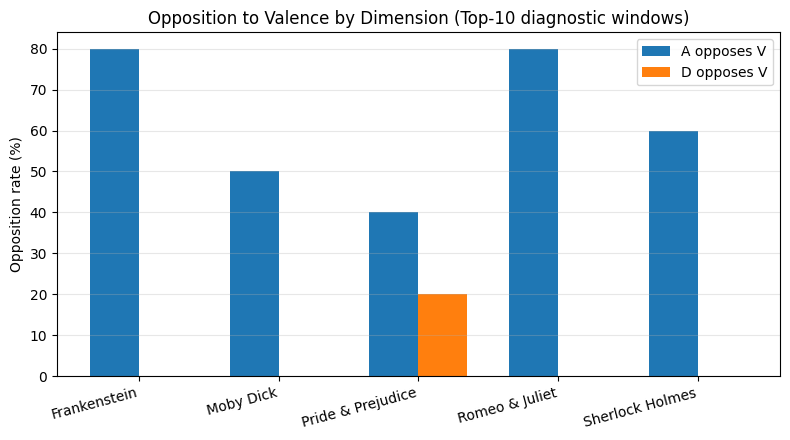

Saved: /Users/nageshs/Desktop/college/emobook/emobook/notebooks/figs/fig_opposition_rates.png


In [3]:
# %%
# Melt %opp into long form for stacked or grouped bar plotting
opp_df = (tab[["title","pct_opp_A","pct_opp_D"]]
          .rename(columns={"pct_opp_A":"A", "pct_opp_D":"D"})
          .melt(id_vars="title", var_name="dim", value_name="percent"))

# Plot: grouped bars (A and D) per title
fig, ax = plt.subplots(figsize=(8, 4.5))
titles = opp_df["title"].unique()
x = np.arange(len(titles))
width = 0.35

A_vals = [float(opp_df[(opp_df.title==t)&(opp_df.dim=="A")]["percent"]) for t in titles]
D_vals = [float(opp_df[(opp_df.title==t)&(opp_df.dim=="D")]["percent"]) for t in titles]

ax.bar(x - width/2, A_vals, width, label="A opposes V")
ax.bar(x + width/2, D_vals, width, label="D opposes V")

ax.set_xticks(x)
ax.set_xticklabels(titles, rotation=15, ha="right")
ax.set_ylabel("Opposition rate (%)")
ax.set_title("Opposition to Valence by Dimension (Top-10 diagnostic windows)")
ax.legend()
ax.grid(axis="y", alpha=0.3)

fig.tight_layout()
fig_path = FIG_DIR / "fig_opposition_rates.png"
plt.savefig(fig_path, dpi=200)
plt.show()
print("Saved:", fig_path)


/var/folders/k0/h7lvf47d4z31ztdbyt2m05rr0000gn/T/ipykernel_12326/4237914113.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tab["title"], rotation=15, ha="right")


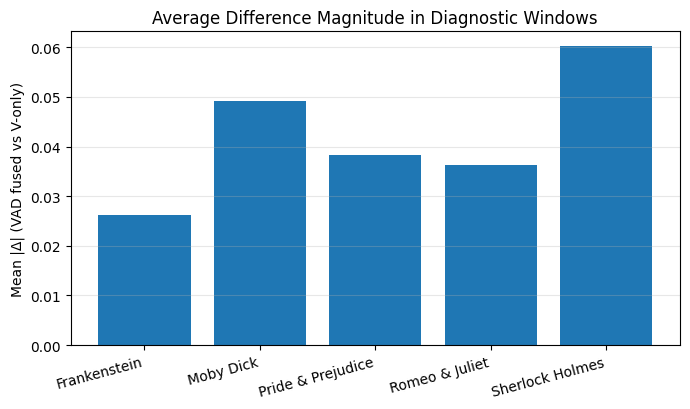

Saved: /Users/nageshs/Desktop/college/emobook/emobook/notebooks/figs/fig_mean_diff_abs.png


In [4]:
# %%
fig, ax = plt.subplots(figsize=(7, 4.2))
ax.bar(tab["title"], tab["mean_diff_abs"])
ax.set_ylabel("Mean |Δ| (VAD fused vs V-only)")
ax.set_title("Average Difference Magnitude in Diagnostic Windows")
ax.set_xticklabels(tab["title"], rotation=15, ha="right")
ax.grid(axis="y", alpha=0.3)

fig.tight_layout()
fig_path2 = FIG_DIR / "fig_mean_diff_abs.png"
plt.savefig(fig_path2, dpi=200)
plt.show()
print("Saved:", fig_path2)


In [5]:
# %%
print("Table S1 saved to:")
print(" -", table_csv)
print(" -", table_xlsx)

display(tab.head(len(tab)))


Table S1 saved to:
 - /Users/nageshs/Desktop/college/emobook/emobook/notebooks/tables/table_S1_summary.csv
 - /Users/nageshs/Desktop/college/emobook/emobook/notebooks/tables/table_S1_summary.xlsx


,book,title,num_chunks,words_total,mean_words_per_chunk,min_words_per_chunk,max_words_per_chunk,target,stride,cap,method,avg_coverage,mean_theta_deg,pct_opp_A,pct_opp_D,mean_diff_abs
0,Frankenstein.clean,Frankenstein,1559,75023,108.04,70,220,120,60,220,sentence+word-pack,0.686990,80.200115,80.0,0.0,0.026167
1,Mobi Dick.clean,Moby Dick,4194,212780,110.48,61,220,120,60,220,sentence+word-pack,0.693745,69.186972,50.0,0.0,0.049134
2,Pride and Prejudice.clean,Pride & Prejudice,2598,127359,108.91,65,220,120,60,220,sentence+word-pack,0.698676,51.307350,40.0,20.0,0.038346
3,Romeo and Juliet.clean,Romeo & Juliet,499,25946,111.88,66,205,120,60,220,sentence+word-pack,0.678822,85.071382,80.0,0.0,0.036376
4,The Adventures of Sherlock Holmes.clean,Sherlock Holmes,2168,104496,108.08,62,220,120,60,220,sentence+word-pack,0.697337,74.944499,60.0,0.0,0.060211
